# 📘 Customer Segmentation ML Project
# Full Pipeline: EDA → Preprocessing → Modeling → Evaluation

# **1: Import Libraries**

In [28]:
import pandas as pd  # for handling tabular data
import numpy as np  # for numerical operations
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # for more attractive plots
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # for feature scaling
from sklearn.decomposition import PCA  # for dimensionality reduction
from sklearn.cluster import KMeans, DBSCAN  # clustering algorithms
from sklearn.mixture import GaussianMixture  # GMM clustering
from sklearn.metrics import silhouette_score  # for evaluating clustering
import warnings
warnings.filterwarnings('ignore')  # hide unnecessary warnings


# **2. Load Data**

In [29]:
#Load the dataset
df = pd.read_excel("/kaggle/input/customer-segmentation-datset/Online Retail.xlsx")

In [30]:
df.head()# display first 5 rows - We're reading the dataset and checking its structure.

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **3: Exploratory Data Analysis**
We inspect the dataset shape, nulls, and summary to guide cleaning.

In [31]:
# check the data info
print("\n---Basic Info---")
df.info()


---Basic Info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [32]:
# data Null vlaues
print("\n---Null Values---")
df.isnull().sum()


---Null Values---


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [33]:
print("\n---Description---")
df.describe()


---Description---


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


# **4. Data Cleaning**

In [34]:
# Remove Missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)  # remove rows where CustomerID is missing

Now our data has never any null values

In [35]:
# verify that nul value is remove from CustomerID
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [36]:
df["Quantity"]

0          6
1          6
2          8
3          6
4          6
          ..
541904    12
541905     6
541906     4
541907     4
541908     3
Name: Quantity, Length: 406829, dtype: int64

In [37]:
# Remove negative and zero quantity/price
# keep only positive quantity and price
df = df[df["Quantity"]>0]
df = df[df["UnitPrice"]>0]

In [38]:
# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"]

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 397884, dtype: datetime64[ns]

In [40]:
#Add TotalPrice Column
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df["TotalPrice"]

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: TotalPrice, Length: 397884, dtype: float64

# **5: Feature Engineering: (RFM)**
We'll create RFM features (Recency, Frequency, Monetary) per customer:

Recency: Days since the last purchase

Frequency: Number of transactions

Monetary: Total money spent

In [42]:
reference_date = df["InvoiceDate"].max()  # latest date in the data
reference_date

Timestamp('2011-12-09 12:50:00')

In [47]:
# We calculate Recency, Frequency, and Monetary values per customer.
rfm = df.groupby("CustomerID").agg({
    'InvoiceDate' : lambda x: (reference_date - x.max()).days,  # Recency
    "InvoiceNo" : "nunique", # Frequency
    "TotalPrice": 'sum'  # Monetary
}).reset_index()

In [48]:
rfm

,CustomerID,InvoiceDate,InvoiceNo,TotalPrice
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
...,...,...,...,...
4333,18280.0,277,1,180.60
4334,18281.0,180,1,80.82
4335,18282.0,7,2,178.05
4336,18283.0,3,16,2094.88


In [50]:
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

# **6. RFM Scoring**

In [57]:
# We score each customer from 1–5 on each RFM dimension and sum for total score.
rfm["R_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method='first'),5,labels=[1,2,3,4,5]).astype(int)
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]).astype(int)
rfm["RFM_Score"]= rfm["R_Score"] + rfm["F_Score"] + rfm["M_Score"]

In [58]:
rfm["RFM_Score"]

0        7
1       15
2       10
3        9
4        4
        ..
4333     4
4334     4
4335     9
4336    15
4337    11
Name: RFM_Score, Length: 4338, dtype: int64

# **7. Normalization / Scaling**
We normalize data so clustering isn't biased by scale.

In [60]:
features = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()   # scales data to mean=0, std=1
scaled_features = scaler.fit_transform(features)

In [61]:
scaled_features

array([[ 2.33457414e+00, -4.25096503e-01,  8.35866818e+00],
       [-9.05340320e-01,  3.54416797e-01,  2.50966264e-01],
       [-1.75359593e-01, -3.53398530e-02, -2.85960063e-02],
       ...,
       [-8.45341904e-01, -2.95177619e-01, -2.08742313e-01],
       [-8.85340848e-01,  1.52368675e+00,  4.51854273e-03],
       [-4.95351144e-01, -1.65258736e-01, -2.41412739e-02]])

# **8. PCA**
 PCA helps simplify clustering and visualize results in 2D.

In [78]:
pca = PCA(n_components = 2) # reduce to 2 components for visualization
rfm_pca = pca.fit_transform(scaled_features)

In [63]:
rfm_pca

array([[ 4.10662331,  5.4335794 ],
       [ 0.74241056, -0.67130042],
       [ 0.02480234, -0.174954  ],
       ...,
       [-0.00950854, -0.8885143 ],
       [ 1.36851597, -0.5982692 ],
       [ 0.0616734 , -0.47997182]])

# **9: Clustering: K-Means**
We use silhouette score to pick the best number of clusters for KMeans.

In [68]:
scores = []
for k in range(2, 11): # test different cluster numbers
    kmeans = KMeans(n_clusters=k, random_state=42).fit(rfm_pca)
    scores.append(silhouette_score(rfm_pca, kmeans.labels_))  # measure how well-separated clusters are

In [69]:
scores

[0.8908953144413646,
 0.6166568158775805,
 0.6350875876423195,
 0.6064627918077389,
 0.5403447789156751,
 0.49184476010740874,
 0.4563171868333857,
 0.45611908916428034,
 0.4507094544137784]

In [70]:
optimal_k = np.argmax(scores) + 2 # best K from silhouette scores
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(rfm_pca)
rfm["KMeans_Cluster"] = kmeans_labels

In [71]:
rfm["KMeans_Cluster"]

0       0
1       0
2       0
3       0
4       0
       ..
4333    0
4334    0
4335    0
4336    0
4337    0
Name: KMeans_Cluster, Length: 4338, dtype: int32

# **10. Clustering: DBSCAN**
 DBSCAN finds clusters based on density – good for irregular shapes.

In [73]:
dbscan = DBSCAN(eps=0.5, min_samples=5)# density-based clustering
dbscan_labels = dbscan.fit_predict(rfm_pca)
rfm['DBSCAN_Cluster'] = dbscan_labels

# **11. CLUSTERING: GMM**
GMM assumes data comes from overlapping Gaussian distributions.

In [74]:
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(rfm_pca)
rfm["GMM_Cluster"] = gmm_labels

# **12. VISUALIZATION**
We visualize clusters from all 3 methods on 2D PCA-reduced data.

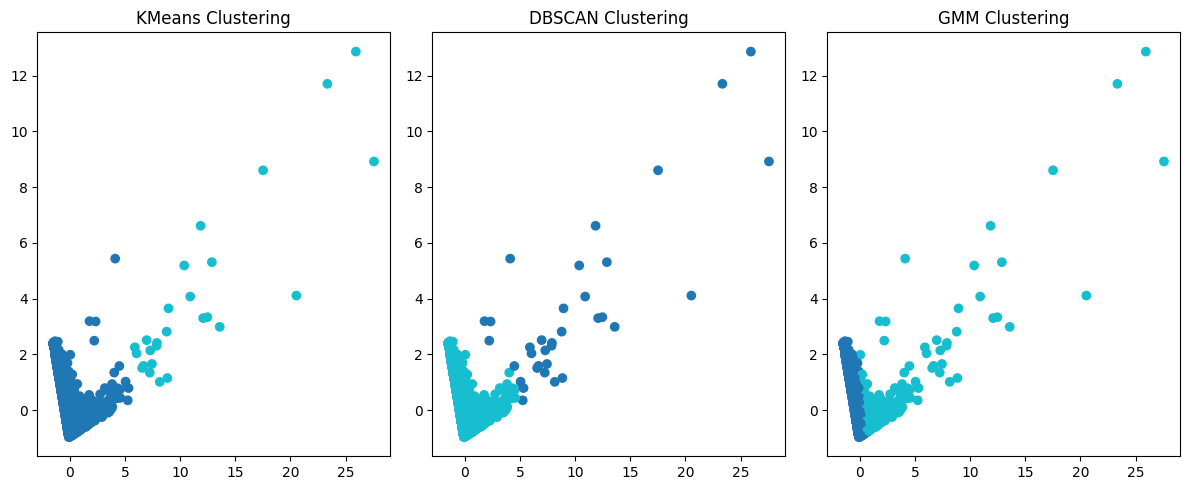

In [75]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=rfm['KMeans_Cluster'], cmap='tab10')
plt.title('KMeans Clustering')

plt.subplot(1,3,2)
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=rfm['DBSCAN_Cluster'], cmap='tab10')
plt.title('DBSCAN Clustering')

plt.subplot(1,3,3)
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=rfm['GMM_Cluster'], cmap='tab10')
plt.title('GMM Clustering')
plt.tight_layout()
plt.show()

# **13. EVALUATION**
 We evaluate clustering using the Silhouette Score (higher is better).

In [77]:
print("\nSilhouette Score - KMeans:", silhouette_score(rfm_pca, kmeans_labels))
print("Silhouette Score - GMM:", silhouette_score(rfm_pca, gmm_labels))

# DBSCAN may assign -1 for noise, skip if many -1
if len(set(dbscan_labels)) > 1:  # Check if DBSCAN created any real clusters
    print("Silhouette Score - DBSCAN:", silhouette_score(rfm_pca, dbscan_labels)) 
else:
    print("DBSCAN clustering not meaningful due to too many outliers (-1 labels)")


Silhouette Score - KMeans: 0.8908953144413646
Silhouette Score - GMM: 0.4025931773287145
Silhouette Score - DBSCAN: 0.8727768837254027
